In [10]:
# Import libs
from bs4 import BeautifulSoup
import requests
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import re as re
from pandas.io.json import json_normalize
import json # library to handle JSON files
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 
import geocoder
import geopandas as gpd
import fiona

# Prepare neighborhood list: Manhattan

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_Manhattan_neighborhoods'
results = requests.get(url)
soup = BeautifulSoup(results.content)

In [3]:
MA_info = soup.find_all('table', attrs = {'class':'wikitable sortable'})

In [4]:
MA_list = []
for area in MA_info:
    list_data = area.tbody.find_all('tr')
    for row in list_data[1:]:
        MA_list.append(row.find('td').text.replace('\n', '').strip())
    for index, neighborhood in enumerate(MA_list):
        try:
            MA_list[index] = re.split('[(,\[†]', neighborhood)[0].strip()
        except:
            pass
    for index, neighborhood in enumerate(MA_list):
        try:
            MA_list[index] = neighborhood.split(' aka ')[0].strip()
        except:
            pass
MA_list[-3] = MA_list[-3].replace('Historical District','').strip()
MA_list[62] = MA_list[62].replace('and Loisaida', '').strip()
MA_list

['Upper Manhattan',
 'Marble Hill',
 'Inwood',
 'Fort George',
 'Washington Heights',
 'Hudson Heights',
 'West Harlem',
 'Hamilton Heights',
 'Manhattanville',
 'Morningside Heights',
 'Central Harlem',
 'Harlem',
 'St. Nicholas Historic District',
 'Astor Row',
 'Sugar Hill',
 'Marcus Garvey Park',
 'Le Petit Senegal',
 'East Harlem',
 'Upper East Side',
 'Lenox Hill',
 'Carnegie Hill',
 'Yorkville',
 'Upper West Side',
 'Manhattan Valley',
 'Lincoln Square',
 'Columbus Circle',
 'Sutton Place',
 'Rockefeller Center',
 'Diamond District',
 'Theater District',
 'Turtle Bay',
 'Midtown East',
 'Midtown',
 'Tudor City',
 'Little Brazil',
 'Times Square',
 'Hudson Yards',
 'Midtown West',
 "Hell's Kitchen",
 'Garment District',
 'Herald Square',
 'Koreatown',
 'Murray Hill',
 'Tenderloin',
 'Madison Square',
 'Flower District',
 'Brookdale',
 'Hudson Yards',
 'Kips Bay',
 'Rose Hill',
 'NoMad',
 'Peter Cooper Village',
 'Chelsea',
 'Flatiron District',
 'Gramercy Park',
 'Stuyvesant Squa

# Prepare neighborhood list: DC

In [5]:
url = 'https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/Administrative_Other_Boundaries_WebMercator/MapServer/35/query?where=1%3D1&outFields=NAME&outSR=4326&f=json'
results = requests.get(url).json()
DC_list_full = json_normalize(results['features'])
DC_list_full.columns = ['Name', 'Latitude', 'Longitude']

<ipython-input-5-036be7523f7b>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  DC_list_full = json_normalize(results['features'])


In [6]:
DC_list_full['Name'] = DC_list_full['Name'].str.replace('-',' ', regex=False)

def name_correct(name, delimit='/'):
    return name.split(delimit)[0]

DC_list_full['Name'] = DC_list_full['Name'].apply(name_correct)
DC_list = DC_list_full['Name'].tolist()
DC_list

['Fort Stanton',
 'Congress Heights',
 'Washington Highlands',
 'Bellevue',
 'Knox Hill',
 'Shipley',
 'Douglass',
 'Woodland',
 'Garfield Heights',
 'Near Southeast',
 'Capitol Hill',
 'Dupont Park',
 'Twining',
 'Randle Highlands',
 'Fairlawn',
 'Penn Branch',
 'Barry Farm',
 'Historic Anacostia',
 'Columbia Heights',
 'Logan Circle',
 'Cardozo',
 'Van Ness',
 'Forest Hills',
 'Georgetown Reservoir',
 'Foxhall Village',
 'Fort Totten',
 'Pleasant Hill',
 'Kenilworth',
 'Eastland Gardens',
 'Deanwood',
 'Fort Dupont',
 'Greenway',
 'Woodland Normanstone',
 'Mass. Ave. Heights',
 'Naylor Gardens',
 'Pleasant Plains',
 'Hillsdale',
 'Benning Ridge',
 'Penn Quarter',
 'Chinatown',
 'Stronghold',
 'South Central',
 'Langston',
 'Downtown East',
 'North Portal Estates',
 'Colonial Village',
 'Shepherd Park',
 'Takoma',
 'Lamond Riggs',
 'Petworth',
 'Brightwood Park',
 'Manor Park',
 'Brightwood',
 'Hawthorne',
 'Barnaby Woods',
 'Queens Chapel',
 'Michigan Park',
 'North Michigan Park',
 

## Function to generate points in polygon

In [16]:
from shapely.geometry import Point
import matplotlib.pyplot as plt
import random

def random_points_in_polygon(number, polygon, seed=10):
    random.seed(seed)
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  # returns list of shapely point

# Prepare neighborhood list: Beijing

In [92]:
# Density of neighborhood in DC
neighborhood_dens_DC = len(DC_list) / 68.34
neighborhood_dens_MA = len(MA_list) / 22.82
print('DC: {} per sq mi'.format(neighborhood_dens_DC))
print('MA: {} per sq mi'.format(neighborhood_dens_MA))

DC: 1.9315188762071993 per sq mi
MA: 3.6809815950920246 per sq mi


In [93]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
BJ_downtown = gpd.read_file('Beijing.kml', driver='KML')

In [94]:
num_BJ = int(neighborhood_dens_DC * 60.8)
points = random_points_in_polygon(num_BJ, BJ_downtown.iloc[0].geometry, seed=3)

# Coordinates of the first point
BJ_x = [point.x for point in points]
BJ_y = [point.y for point in points]

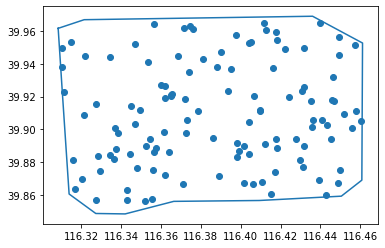

In [95]:
plt.plot(*BJ_downtown.iloc[0,2].exterior.xy)
plt.scatter(BJ_x, BJ_y)

# Prepare neighborhood list: Shanghai

In [120]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
SH_downtown = gpd.read_file('Shanghai.kml', driver='KML')

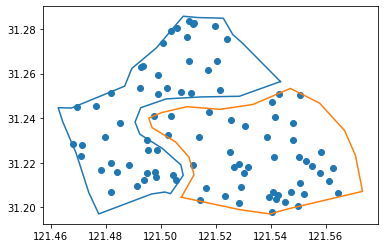

In [172]:
num_SH = int(neighborhood_dens_MA * 24.1/2)
seed0 = 9
points1 = random_points_in_polygon(num_SH, SH_downtown.iloc[0].geometry, seed=seed0)
points2 = random_points_in_polygon(num_SH, SH_downtown.iloc[1].geometry, seed=seed0)

# Coordinates of the first point
SH_x = [point.x for point in points1] + [point.x for point in points2]
SH_y = [point.y for point in points1] + [point.y for point in points2]
plt.plot(*SH_downtown.iloc[0,2].exterior.xy)
plt.plot(*SH_downtown.iloc[1,2].exterior.xy)
plt.scatter(SH_x, SH_y)

# Request neighborhood position

## Mahattan

In [58]:
lat = []
lng = []
for neighborhood in MA_list:
    address = '{}, New York, NY'.format(neighborhood)
    g = geocoder.arcgis(address)
    lat.append(g.lat)
    lng.append(g.lng)

In [59]:
MA_table = pd.DataFrame(MA_list)
MA_table.columns = ['Neighborhoods']
MA_table

,Neighborhoods
0,Upper Manhattan
1,Marble Hill
2,Inwood
3,Fort George
4,Washington Heights
...,...
79,Civic Center
80,Radio Row
81,South Street Seaport
82,Battery Park City


In [60]:
MA_table['Latitude'] = lat
MA_table['Longitude'] = lng
MA_table

,Neighborhoods,Latitude,Longitude
0,Upper Manhattan,40.808810,-73.947770
1,Marble Hill,40.876410,-73.911000
2,Inwood,40.865950,-73.926070
3,Fort George,40.859187,-73.926459
4,Washington Heights,40.849830,-73.936030
...,...,...,...
79,Civic Center,40.713370,-74.003800
80,Radio Row,40.843567,-73.818163
81,South Street Seaport,40.705710,-74.001840
82,Battery Park City,40.711310,-74.015900


In [61]:
for row in range(MA_table.shape[0]):
    if (MA_table.loc[row, 'Latitude'] <= 40.65526141744085) or (MA_table.loc[row, 'Longitude'] >= -73.81816282365787):
        MA_table.drop(row, inplace=True)
MA_table.reset_index(drop=True, inplace=True)
MA_table

,Neighborhoods,Latitude,Longitude
0,Upper Manhattan,40.808810,-73.947770
1,Marble Hill,40.876410,-73.911000
2,Inwood,40.865950,-73.926070
3,Fort George,40.859187,-73.926459
4,Washington Heights,40.849830,-73.936030
...,...,...,...
73,Tribeca,40.718540,-74.008880
74,Civic Center,40.713370,-74.003800
75,South Street Seaport,40.705710,-74.001840
76,Battery Park City,40.711310,-74.015900


## Map of Mahattan

In [41]:
address = 'New York, NY'

g = geocoder.arcgis(address)
print(g.lat, g.lng)

40.71455000000003 -74.00713999999994


In [42]:
map_newyork = folium.Map(location=[g.lat, g.lng], zoom_start=12)

for neighborhood, lat, lng in zip(MA_table['Neighborhoods'], MA_table['Latitude'], MA_table['Longitude']):
    label = '{},{}'.format(lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_newyork)
map_newyork

## Request venues from Foursquare

### Define a required function

In [62]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    neighborhood_venues_info = []
    venues_info = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        neighborhood_venues_info.append(results)
        venues_info.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        print(len(venues_info), ':', name)

    nearby_venues = pd.DataFrame([item for venue_info in venues_info for item in venue_info])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues, venues_info, neighborhood_venues_info)

### Define Foursquare credential and version

In [63]:
CLIENT_ID = 'OQWZRAUBBN5XX5CTG4QJNUTGB1PLERCI32GLZWVRG4JJTOMN' # your Foursquare ID
CLIENT_SECRET = '5J0EYVSGK2QSQXGA4TN5YPIIUY1NU0HDIRQNHRWWB4BXUUAR' # your Foursquare Secret
ACCESS_TOKEN = 'VH53ZCZMIQSN033ZU2VDUZD1CRA5GJQE1SKGVRWNNF1FJINZ' # your FourSquare Access Token
VERSION = '20180605'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OQWZRAUBBN5XX5CTG4QJNUTGB1PLERCI32GLZWVRG4JJTOMN
CLIENT_SECRET:5J0EYVSGK2QSQXGA4TN5YPIIUY1NU0HDIRQNHRWWB4BXUUAR


In [217]:
names = MA_table['Neighborhoods'].tolist()
latitudes = MA_table['Latitude'].tolist()
longitudes = MA_table['Longitude'].tolist()
# MA_venues, MA_venues_info, MA_neighborhood_venues_info = getNearbyVenues(names, latitudes=latitudes, longitudes=longitudes)

### Read already requested data

In [213]:
# Save requested data
import json

MA_venues.to_csv('MA_venues.csv',index=False)
with open('MA_venues_info.txt','w') as fp:
    json.dump(MA_venues_info, fp)
with open('MA_neighborhood_venues_info.txt','w') as fp:
    json.dump(MA_neighborhood_venues_info, fp)

In [214]:
# Load saved data
MA_venues = pd.read_csv('MA_venues.csv')

with open('MA_venues_info.txt', 'r') as fp:
    MA_venues_info_backup = json.load(fp)
with open('MA_neighborhood_venues_info.txt', 'r') as fp:
    MA_neighborhood_venues_info_backup = json.load(fp)

___
## DC

In [65]:
lat = []
lng = []
for neighborhood in DC_list:
    address = '{}, Washington, DC'.format(neighborhood)
    g = geocoder.arcgis(address)
    lat.append(g.lat)
    lng.append(g.lng)

In [66]:
DC_table = pd.DataFrame(DC_list)
DC_table.columns = ['Neighborhoods']
DC_table

,Neighborhoods
0,Fort Stanton
1,Congress Heights
2,Washington Highlands
3,Bellevue
4,Knox Hill
...,...
127,Fort Davis Park
128,Fairfax Village
129,Hillcrest
130,Crestwood


In [67]:
DC_table['Latitude'] = lat
DC_table['Longitude'] = lng
DC_table

,Neighborhoods,Latitude,Longitude
0,Fort Stanton,38.85760,-76.97830
1,Congress Heights,38.84290,-77.00057
2,Washington Highlands,38.83198,-76.99700
3,Bellevue,38.82654,-77.00870
4,Knox Hill,38.85302,-76.97246
...,...,...,...
127,Fort Davis Park,38.86794,-76.94493
128,Fairfax Village,38.86372,-76.95220
129,Hillcrest,38.85941,-76.95566
130,Crestwood,38.94187,-77.03989


In [46]:
# for row in range(MA_table.shape[0]):
#     if (MA_table.loc[row, 'Latitude'] <= 40.65526141744085) or (MA_table.loc[row, 'Longitude'] >= -73.81816282365787):
#         MA_table.drop(row, inplace=True)
# MA_table.reset_index(drop=True, inplace=True)
# MA_table

## Map of DC

In [68]:
address = 'Washington, DC'
g = geocoder.arcgis(address)
print(g.lat, g.lng)

38.890370000000075 -77.03195999999997


In [69]:
map_DC = folium.Map(location=[g.lat, g.lng], zoom_start=12)

for neighborhood, lat, lng in zip(DC_table['Neighborhoods'], DC_table['Latitude'], DC_table['Longitude']):
    label = '{},{}'.format(lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_DC)
map_DC

### Define Foursquare credential and version

In [70]:
names = DC_table['Neighborhoods'].tolist()
latitudes = DC_table['Latitude'].tolist()
longitudes = DC_table['Longitude'].tolist()
# DC_venues, DC_venues_info, DC_neighborhood_venues_info = getNearbyVenues(names, latitudes=latitudes, longitudes=longitudes)

1 : Fort Stanton
2 : Congress Heights
3 : Washington Highlands
4 : Bellevue
5 : Knox Hill
6 : Shipley
7 : Douglass
8 : Woodland
9 : Garfield Heights
10 : Near Southeast
11 : Capitol Hill
12 : Dupont Park
13 : Twining
14 : Randle Highlands
15 : Fairlawn
16 : Penn Branch
17 : Barry Farm
18 : Historic Anacostia
19 : Columbia Heights
20 : Logan Circle
21 : Cardozo
22 : Van Ness
23 : Forest Hills
24 : Georgetown Reservoir
25 : Foxhall Village
26 : Fort Totten
27 : Pleasant Hill
28 : Kenilworth
29 : Eastland Gardens
30 : Deanwood
31 : Fort Dupont
32 : Greenway
33 : Woodland Normanstone
34 : Mass. Ave. Heights
35 : Naylor Gardens
36 : Pleasant Plains
37 : Hillsdale
38 : Benning Ridge
39 : Penn Quarter
40 : Chinatown
41 : Stronghold
42 : South Central
43 : Langston
44 : Downtown East
45 : North Portal Estates
46 : Colonial Village
47 : Shepherd Park
48 : Takoma
49 : Lamond Riggs
50 : Petworth
51 : Brightwood Park
52 : Manor Park
53 : Brightwood
54 : Hawthorne
55 : Barnaby Woods
56 : Queens Cha

### Read saved data

In [216]:
# Save requested data
import json

DC_venues.to_csv('DC_venues.csv',index=False)
with open('DC_venues_info.txt','w') as fp:
    json.dump(DC_venues_info, fp)
with open('DC_neighborhood_venues_info.txt','w') as fp:
    json.dump(DC_neighborhood_venues_info, fp)

In [214]:
# Load saved data
DC_venues = pd.read_csv('DC_venues.csv')

with open('DC_venues_info.txt', 'r') as fp:
    DC_venues_info_backup = json.load(fp)
with open('DC_neighborhood_venues_info.txt', 'r') as fp:
    DC_neighborhood_venues_info_backup = json.load(fp)

___
## Beijing

In [99]:
BJ_list = []
for i in range(len(BJ_y)):
    name = 'Neighborhood{}'.format(i+1)
    BJ_list.append(name)
lat = BJ_y
lng = BJ_x
print(BJ_list)

['Neighborhood1', 'Neighborhood2', 'Neighborhood3', 'Neighborhood4', 'Neighborhood5', 'Neighborhood6', 'Neighborhood7', 'Neighborhood8', 'Neighborhood9', 'Neighborhood10', 'Neighborhood11', 'Neighborhood12', 'Neighborhood13', 'Neighborhood14', 'Neighborhood15', 'Neighborhood16', 'Neighborhood17', 'Neighborhood18', 'Neighborhood19', 'Neighborhood20', 'Neighborhood21', 'Neighborhood22', 'Neighborhood23', 'Neighborhood24', 'Neighborhood25', 'Neighborhood26', 'Neighborhood27', 'Neighborhood28', 'Neighborhood29', 'Neighborhood30', 'Neighborhood31', 'Neighborhood32', 'Neighborhood33', 'Neighborhood34', 'Neighborhood35', 'Neighborhood36', 'Neighborhood37', 'Neighborhood38', 'Neighborhood39', 'Neighborhood40', 'Neighborhood41', 'Neighborhood42', 'Neighborhood43', 'Neighborhood44', 'Neighborhood45', 'Neighborhood46', 'Neighborhood47', 'Neighborhood48', 'Neighborhood49', 'Neighborhood50', 'Neighborhood51', 'Neighborhood52', 'Neighborhood53', 'Neighborhood54', 'Neighborhood55', 'Neighborhood56', 

In [102]:
BJ_table = pd.DataFrame(BJ_list)
BJ_table.columns = ['Neighborhoods']
BJ_table['Latitude'] = lat
BJ_table['Longitude'] = lng
BJ_table

,Neighborhoods,Latitude,Longitude
0,Neighborhood1,39.914085,116.344723
1,Neighborhood2,39.921269,116.364888
2,Neighborhood3,39.949377,116.310378
3,Neighborhood4,39.876788,116.347990
4,Neighborhood5,39.905183,116.460480
...,...,...,...
112,Neighborhood113,39.894349,116.417763
113,Neighborhood114,39.870076,116.320574
114,Neighborhood115,39.921331,116.365395
115,Neighborhood116,39.894352,116.427935


## Map of Beijing

In [103]:
address = 'Beijing, China'
g = geocoder.arcgis(address)
print(g.lat, g.lng)

39.90750000000003 116.39723000000004


In [104]:
map_BJ = folium.Map(location=[g.lat, g.lng], zoom_start=12)

for neighborhood, lat, lng in zip(BJ_table['Neighborhoods'], BJ_table['Latitude'], BJ_table['Longitude']):
#     label = '{},{}'.format(lat, lng)
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_BJ)
map_BJ

### Define Foursquare credential and version

In [105]:
names = BJ_table['Neighborhoods'].tolist()
latitudes = BJ_table['Latitude'].tolist()
longitudes = BJ_table['Longitude'].tolist()
# BJ_venues, BJ_venues_info, BJ_neighborhood_venues_info = getNearbyVenues(names, latitudes=latitudes, longitudes=longitudes)

1 : Neighborhood1
2 : Neighborhood2
3 : Neighborhood3
4 : Neighborhood4
5 : Neighborhood5
6 : Neighborhood6
7 : Neighborhood7
8 : Neighborhood8
9 : Neighborhood9
10 : Neighborhood10
11 : Neighborhood11
12 : Neighborhood12
13 : Neighborhood13
14 : Neighborhood14
15 : Neighborhood15
16 : Neighborhood16
17 : Neighborhood17
18 : Neighborhood18
19 : Neighborhood19
20 : Neighborhood20
21 : Neighborhood21
22 : Neighborhood22
23 : Neighborhood23
24 : Neighborhood24
25 : Neighborhood25
26 : Neighborhood26
27 : Neighborhood27
28 : Neighborhood28
29 : Neighborhood29
30 : Neighborhood30
31 : Neighborhood31
32 : Neighborhood32
33 : Neighborhood33
34 : Neighborhood34
35 : Neighborhood35
36 : Neighborhood36
37 : Neighborhood37
38 : Neighborhood38
39 : Neighborhood39
40 : Neighborhood40
41 : Neighborhood41
42 : Neighborhood42
43 : Neighborhood43
44 : Neighborhood44
45 : Neighborhood45
46 : Neighborhood46
47 : Neighborhood47
48 : Neighborhood48
49 : Neighborhood49
50 : Neighborhood50
51 : Neighborhood5

### Read saved data

In [219]:
# Save requested data
import json

BJ_venues.to_csv('BJ_venues.csv',index=False)
with open('BJ_venues_info.txt','w') as fp:
    json.dump(BJ_venues_info, fp)
with open('BJ_neighborhood_venues_info.txt','w') as fp:
    json.dump(BJ_neighborhood_venues_info, fp)

In [214]:
# Load saved data
BJ_venues = pd.read_csv('BJ_venues.csv')

with open('BJ_venues_info.txt', 'r') as fp:
    BJ_venues_info_backup = json.load(fp)
with open('BJ_neighborhood_venues_info.txt', 'r') as fp:
    BJ_neighborhood_venues_info_backup = json.load(fp)

___
## Shanghai

In [173]:
SH_list = []
for i in range(len(SH_y)):
    name = 'Neighborhood{}'.format(i+1)
    SH_list.append(name)
lat = SH_y
lng = SH_x
print(SH_list)

['Neighborhood1', 'Neighborhood2', 'Neighborhood3', 'Neighborhood4', 'Neighborhood5', 'Neighborhood6', 'Neighborhood7', 'Neighborhood8', 'Neighborhood9', 'Neighborhood10', 'Neighborhood11', 'Neighborhood12', 'Neighborhood13', 'Neighborhood14', 'Neighborhood15', 'Neighborhood16', 'Neighborhood17', 'Neighborhood18', 'Neighborhood19', 'Neighborhood20', 'Neighborhood21', 'Neighborhood22', 'Neighborhood23', 'Neighborhood24', 'Neighborhood25', 'Neighborhood26', 'Neighborhood27', 'Neighborhood28', 'Neighborhood29', 'Neighborhood30', 'Neighborhood31', 'Neighborhood32', 'Neighborhood33', 'Neighborhood34', 'Neighborhood35', 'Neighborhood36', 'Neighborhood37', 'Neighborhood38', 'Neighborhood39', 'Neighborhood40', 'Neighborhood41', 'Neighborhood42', 'Neighborhood43', 'Neighborhood44', 'Neighborhood45', 'Neighborhood46', 'Neighborhood47', 'Neighborhood48', 'Neighborhood49', 'Neighborhood50', 'Neighborhood51', 'Neighborhood52', 'Neighborhood53', 'Neighborhood54', 'Neighborhood55', 'Neighborhood56', 

In [174]:
SH_table = pd.DataFrame(SH_list)
SH_table.columns = ['Neighborhoods']
SH_table['Latitude'] = lat
SH_table['Longitude'] = lng
SH_table

,Neighborhoods,Latitude,Longitude
0,Neighborhood1,31.251737,121.507500
1,Neighborhood2,31.206833,121.481930
2,Neighborhood3,31.279013,121.503619
3,Neighborhood4,31.265728,121.510424
4,Neighborhood5,31.263231,121.493707
...,...,...,...
83,Neighborhood84,31.204721,121.539343
84,Neighborhood85,31.200679,121.549767
85,Neighborhood86,31.236657,121.530747
86,Neighborhood87,31.218571,121.555069


## Map of Shanghai

In [175]:
address = 'Shanghai, China'
g = geocoder.arcgis(address)
print(g.lat, g.lng)

31.22222000000005 121.45806000000005


In [176]:
map_SH = folium.Map(location=[g.lat, g.lng], zoom_start=12)

for neighborhood, lat, lng in zip(SH_table['Neighborhoods'], SH_table['Latitude'], SH_table['Longitude']):
#     label = '{},{}'.format(lat, lng)
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_SH)
map_SH

### Define Foursquare credential and version

In [177]:
names = SH_table['Neighborhoods'].tolist()
latitudes = SH_table['Latitude'].tolist()
longitudes = SH_table['Longitude'].tolist()
# SH_venues, SH_venues_info, SH_neighborhood_venues_info = getNearbyVenues(names, latitudes=latitudes, longitudes=longitudes)

1 : Neighborhood1
2 : Neighborhood2
3 : Neighborhood3
4 : Neighborhood4
5 : Neighborhood5
6 : Neighborhood6
7 : Neighborhood7
8 : Neighborhood8
9 : Neighborhood9
10 : Neighborhood10
11 : Neighborhood11
12 : Neighborhood12
13 : Neighborhood13
14 : Neighborhood14
15 : Neighborhood15
16 : Neighborhood16
17 : Neighborhood17
18 : Neighborhood18
19 : Neighborhood19
20 : Neighborhood20
21 : Neighborhood21
22 : Neighborhood22
23 : Neighborhood23
24 : Neighborhood24
25 : Neighborhood25
26 : Neighborhood26
27 : Neighborhood27
28 : Neighborhood28
29 : Neighborhood29
30 : Neighborhood30
31 : Neighborhood31
32 : Neighborhood32
33 : Neighborhood33
34 : Neighborhood34
35 : Neighborhood35
36 : Neighborhood36
37 : Neighborhood37
38 : Neighborhood38
39 : Neighborhood39
40 : Neighborhood40
41 : Neighborhood41
42 : Neighborhood42
43 : Neighborhood43
44 : Neighborhood44
45 : Neighborhood45
46 : Neighborhood46
47 : Neighborhood47
48 : Neighborhood48
49 : Neighborhood49
50 : Neighborhood50
51 : Neighborhood5

### Read saved data

In [220]:
# Save requested data
import json

SH_venues.to_csv('SH_venues.csv',index=False)
with open('SH_venues_info.txt','w') as fp:
    json.dump(SH_venues_info, fp)
with open('SH_neighborhood_venues_info.txt','w') as fp:
    json.dump(SH_neighborhood_venues_info, fp)

In [214]:
# Load saved data
SH_venues = pd.read_csv('SH_venues.csv')

with open('SH_venues_info.txt', 'r') as fp:
    SH_venues_info_backup = json.load(fp)
with open('SH_neighborhood_venues_info.txt', 'r') as fp:
    SH_neighborhood_venues_info_backup = json.load(fp)

# Exploring and Clustering